# Construct the convex hull diagram
Include the search results from the known phases and the search phases

In [4]:
%aiida
from aiida.orm import StructureData, SinglefileData
from ase.io import read
from aiida.engine import calcfunction, submit
from pathlib import Path
from tqdm.auto import tqdm
from tqdm.auto import tqdm

from toolchest.hull import get_relax_record_single, get_relax_records, print_spg_with_limit, get_entry
import pandas as pd

from aiida_vasp.parsers.file_parsers.potcar import MultiPotcarIo
from pymatgen.entries.computed_entries import ComputedEntry


In [2]:
sgroup_run2 = Group.objects.get(label='li-fe-o-s/run2-airss-refine-structures')
sgroup_run1 = Group.objects.get(label='li-fe-o-s/run1-airss-refine-structures')
extra_group = Group.objects.get(label='li-fe-o-s/extra-search-structures')
kgroup = Group.objects.get(label='li-fe-o-s/mp-structures')

# Construct Structure centric database

## Construct Calculation centric group
Add the collected calculation to a dedicated group

Create the group needed for the hull construction calculations

## Get the data from the Calculation Centric Group

In [5]:
from toolchest.hull import get_relax_records

gcalc = Group.objects.get_or_create(label='li-fe-o-s/pbe-fe-u4-calcs')[0]

# Construct the dataframe

df = get_relax_records([gcalc], 520, group_with_structures=False)

df['entry'] = get_entry(df)
df['n_fe'] = df['pmg_struct'].apply(lambda x: x.composition['Fe'])
df['chemsys'] = df['pmg_struct'].apply(lambda x: x.composition.chemical_system)
df['natoms'] = df['structure'].apply(lambda x: len(x.sites))
df['e_pa'] = df['energy'] / df['natoms']

Entries: 500


  0%|          | 0/500 [00:00<?, ?it/s]

### Extra results from pushing

In [6]:
extra_df = get_relax_records([extra_group], 520)
extra_df['natoms'] = extra_df['structure'].apply(lambda x: len(x.sites))
extra_df['e_pa'] = extra_df['energy'] / extra_df['natoms']
extra_df[extra_df.formula == 'Li2Fe4S3O2']['e_pa']

Entries: 15


  0%|          | 0/15 [00:00<?, ?it/s]

13   -5.557984
14   -5.557988
Name: e_pa, dtype: float64

Write files

In [42]:
df.to_csv('hull_df.csv')

extra_df.to_csv('extra_df.csv')

In [52]:
#Exclude the enumerated structure

df = df[~df.label.str.contains('Enum')]

## Constructing the convex hull

In [53]:
from collections import Counter
from pymatgen.analysis.phase_diagram import PDEntry, PhaseDiagram
from pymatgen import Composition
from toolchest.airssutils import PlotlyPDPlotter
from pymatgen.analysis.phase_diagram import PDPlotter

In [54]:
def df2pd(df, corr=None):
    """
    Generate phase diagram from a DataFrame
    """
    pd_entries = []
    for idx, row in df.iterrows():
        if corr:
            correction  = corr.get_correction(row.entry)
            row.entry.correction = correction
        else:
            row.entry.correction = 0.0
        pd_entries.append(row.entry)

    # Apply gas correction
    #gas_correct = 0.6 # Accounts the O-O overbinding energy
    #for entry in pd_entries:
    #    if entry.composition.chemical_system == 'O':
    #        entry.correction = entry.composition['O'] * gas_correct

    #fe_correct = -0.0 # Correction for using the Wrong Fe...     
    #for entry in pd_entries:
    #    #entry = deepcopy(entry)
    #    if entry.composition.chemical_system == 'Fe':
    #        entry._energy += entry.composition['Fe'] * fe_correct
    return PhaseDiagram(pd_entries)

/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/pymatgen/analysis/phase_diagram.py:2140: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


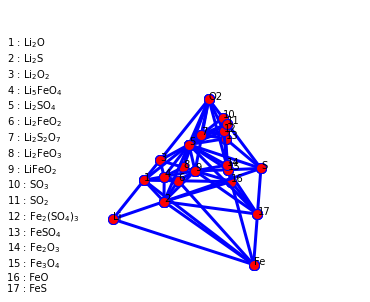

In [55]:
diagram_known = df2pd(df[~(df.label.str.contains('res') | (df.formula == 'Li2FeSO') | (df.label.str.contains('Enum')))], corr=None)

#for entry in diagram_known.all_entries:
#    dist = diagram_known.get_decomp_and_e_above_hull(entry)
#    print(entry.composition.reduced_formula, dist[1])

plotter = PDPlotter(diagram_known, backend='matplotlib', show_unstable=0.05)
plotter.get_plot()
plt.savefig("quanternary_known.png", dpi=300)
plt.show()

/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/pymatgen/analysis/phase_diagram.py:2140: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


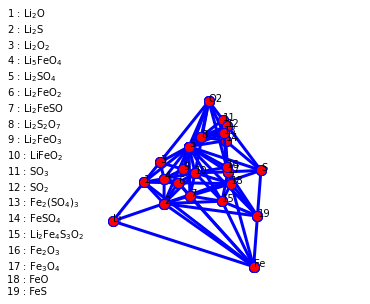

In [56]:
diagram_search = df2pd(df)

plotter = PDPlotter(diagram_search, backend='matplotlib', show_unstable=0.05)
plotter.get_plot(plt=plt)
plt.savefig("quanternary_all.png", dpi=300)

### For finite temperature

In [57]:
from toolchest.predictg import make_g_diagram

In [58]:
diagrams_g = {
    'search': make_g_diagram(diagram_search, 800),
    'known': make_g_diagram(diagram_known, 800)
}
diagrams_h = {
    'search': diagram_search,
    'knwon': diagram_known
}

Add columns for storing additional data such as the e_above_hull

In [59]:
records = []
index = []
for idx, row in df.iterrows():
    entry = row.entry
    decomp, dist_to_hull = diagram_search.get_decomp_and_e_above_hull(entry)
    decomp_knwon, dist_to_hull_known = diagram_known.get_decomp_and_e_above_hull(entry, allow_negative=True)
    records.append({
        'e_above_hull': dist_to_hull,
        'decomp': "+".join([c.composition.reduced_formula for c in decomp]),
        'decomp_known': "+".join([c.composition.reduced_formula for c in decomp_knwon]),
        'e_above_hull_known': dist_to_hull_known,
    })
    index.append(idx)
pd_entries = pd.DataFrame(records, index=index)

Add columns for additiona data at finite temperature

In [60]:
# Assign data to the DataFrame
df_with_pd = pd.concat([df, pd_entries], axis=1).sort_values('e_pa')

# Remove duplicates - some material has been computed multiple times - we simply take the first entry (lowest energy)
mask = df_with_pd.duplicated('structure_uuid', keep='first')
unique = df_with_pd[~mask]

Histogram of the E above hull for all compositions included in the search

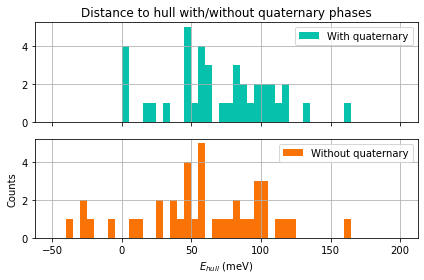

In [61]:
u=4.0

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
# Get the entry closest to the hull for each composition
tmp = unique.groupby('formula')['e_above_hull'].idxmin()
lowest = unique.loc[tmp]

search_lowest = lowest[lowest.label.str.contains("res") | lowest.label.str.contains("Enum")]

(search_lowest['e_above_hull'] * 1000).hist(bins=50, range=(-50, 200), ax=axs[0], label='With quaternary', color='xkcd:turquoise')
(search_lowest['e_above_hull_known']* 1000).hist(bins=50, range=(-50, 200), ax=axs[1], label='Without quaternary', color='xkcd:orange')

axs[1].set_xlabel(r"$E_{hull}$ (meV)")
axs[1].set_ylabel("Counts")
axs[0].set_title("Distance to hull with/without quaternary phases")
axs[0].legend()
axs[1].legend()
fig.tight_layout()

plt.savefig(f"e_above_hull_search-u{u}-all.png", dpi=300)

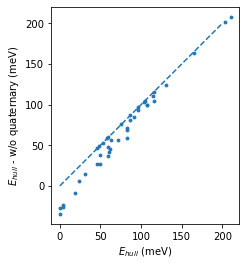

In [62]:
plt.scatter(search_lowest['e_above_hull'] * 1e3, search_lowest['e_above_hull_known'] * 1e3, s=8)
plt.plot([0, 200], [0, 200], '--')
plt.xlabel(r'$E_{hull}$ (meV)')
plt.ylabel(r'$E_{hull}$ - w/o quaternary (meV)')
plt.gca().set_aspect('equal')
plt.savefig('e_hull_with_without_quaternary.png', dpi=300)

## Compute the reaction energies

In [63]:
from pymatgen.analysis.reaction_calculator import ComputedReaction
li2feso = lowest[lowest.formula == 'Li2FeSO'].iloc[0].entry
li2o = lowest[lowest.formula == 'Li2O'].iloc[0].entry
fes = lowest[lowest.formula == 'FeS'].iloc[0].entry
reaction = ComputedReaction([li2o, fes], [li2feso])

print(f'{reaction} energy: {reaction.calculated_reaction_energy:.2f} eV')

Li2O + FeS -> Li2FeSO energy: -0.51 eV


In [64]:
from pymatgen.analysis.reaction_calculator import ComputedReaction
li2feso = lowest[lowest.formula == 'Li2FeSO'].iloc[0].entry
li2s = lowest[lowest.formula == 'Li2S'].iloc[0].entry
feo = lowest[lowest.formula == 'FeO'].iloc[0].entry
reaction = ComputedReaction([li2s, feo], [li2feso])

print(f'{reaction} energy: {reaction.calculated_reaction_energy:.2f} eV')

Li2S + FeO -> Li2FeSO energy: -0.13 eV


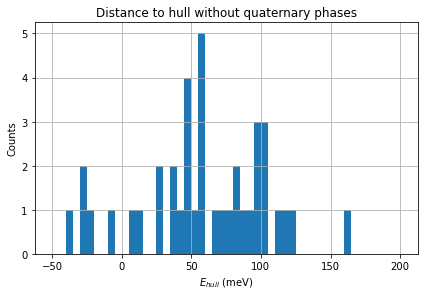

In [65]:
(search_lowest['e_above_hull_known']* 1000).hist(bins=50, range=(-50, 200))

plt.xlabel(r"$E_{hull}$ (meV)")
plt.ylabel("Counts")
plt.tight_layout()
plt.title("Distance to hull without quaternary phases")
plt.savefig(f"e_above_existing_hull_search-u{u}-all.png", dpi=300)

In [66]:
to_show = search_lowest[search_lowest.e_above_hull < 0.150].sort_values('e_above_hull')

data = to_show[['label', 'formula', 'e_above_hull', 'e_pa', 'decomp', 'e_above_hull_known', 'decomp_known', 'relax_uuid']].head(10)
data

,label,formula,e_above_hull,e_pa,decomp,e_above_hull_known,decomp_known,relax_uuid
437,LFSO-Li2FeSO-201025-015107-3451c2.res,Li2FeSO,0.000000,-5.135918,Li2FeSO,-0.026724,FeO+Li2S,c0b4f19c-d4ba-4b2a-a57d-7f2e5c725da4
457,LFSO-Li2Fe4S3O2-201025-153957-9403b6.res,Li2Fe4S3O2,0.000000,-5.557765,Li2Fe4S3O2,-0.035033,FeO+FeS+Li2S,0eb044ae-b073-4ee0-95ef-f2cbbe47adda
479,LFSO-Li2Fe3S2O2-201022-171823-c39cef.res,Li2Fe3(SO)2,0.003356,-5.572475,Li2FeSO+FeO+Li2Fe4S3O2,-0.025476,FeO+FeS+Li2S,1cfbf6af-55ce-42e1-9307-f5ed50e9df86
490,LFSO-Li2Fe2S2O-201022-042623-e6d3a9.res,Li2Fe2S2O,0.003385,-5.220288,Li2Fe4S3O2+Li2S,-0.024141,FeO+FeS+Li2S,2e52c5fc-aff7-4615-9023-2872464d142b
64,LFSO-Li4Fe3S3O2-200926-154112-68ece2.res,Li4Fe3S3O2,0.018077,-5.169032,Li2FeSO+Li2Fe4S3O2+Li2S,-0.009115,FeO+FeS+Li2S,f2da497d-e42d-4fcb-805b-c7c311738cfb
449,LFSO-Li2Fe4S4O-201023-052738-cce6fe.res,Li2Fe4S4O,0.023032,-5.269680,Li2Fe4S3O2+FeS+Li2S,0.005516,FeO+FeS+Li2S,c28c3db0-ffa5-40e7-afe6-cb4b4aaff4b6
61,LFSO-Li4Fe3S4O-200925-201817-7d9406.res,Li4Fe3S4O,0.030539,-4.918526,Li2Fe4S3O2+FeS+Li2S,0.014482,FeO+FeS+Li2S,b3d38d45-96e2-4968-b423-738c50f428c5
104,LFSO-Li4Fe2S3O-200911-023604-a5ffb0.res,Li4Fe2S3O,0.045796,-4.810376,Li2Fe4S3O2+Li2S,0.026528,FeO+FeS+Li2S,f39acdda-fc4f-4d40-93b6-48c8eb06768a
291,LFSO-Li6FeSO3-200909-224307-24378f.res,Li6FeSO3,0.046300,-4.915209,Li2O+Li2FeO2+Li2S,0.046300,Li2FeO2+Li2O+Li2S,32b69034-22a9-4e73-a2f8-73b481029faf
389,LFSO-Li5FeS2O2-201026-013822-cc74e4.res,Li5Fe(SO)2,0.048638,-4.822020,LiFeO2+Li2S,0.048638,LiFeO2+Li2S,d0cd6261-0ac1-4afb-addb-69e6c0d51be9


## Calibration for formation energy

In [23]:
from pymatgen.analysis.reaction_calculator import ComputedReaction

entries_comp = []

li2feso = unique[unique.formula == 'Li2FeSO'].sort_values('e_pa').iloc[0].entry
li2O = unique[unique.formula == 'Li2O'].sort_values('e_pa').iloc[0].entry
fes = unique[unique.formula == 'FeS'].sort_values('e_pa').iloc[0].entry
react = ComputedReaction([li2O, fes], [li2feso])
print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV') 

li2so4 = unique[unique.formula == 'Li2SO4'].sort_values('e_pa').iloc[0].entry

fes2 = unique[unique.formula == 'FeS2'].sort_values('e_pa').iloc[0].entry

fe = unique[unique.formula == 'Fe'].sort_values('e_pa').iloc[0].entry
li2s = unique[unique.formula == 'Li2S'].sort_values('e_pa').iloc[0].entry
s = unique[unique.formula == 'S'].sort_values('e_pa').iloc[0].entry
li2o = unique[unique.formula == 'Li2O'].sort_values('e_pa').iloc[0].entry

feo = unique[unique.formula == 'FeO'].sort_values('e_pa').iloc[0].entry
fe2o3 = unique[unique.formula == 'Fe2O3'].sort_values('e_pa').iloc[0].entry
fe3o4 = unique[unique.formula == 'Fe3O4'].sort_values('e_pa').iloc[0].entry

entries_comp.append([li2O, fes, li2feso, fes2, fe, li2s, s, li2o, feo, fe2o3, fe3o4])

react = ComputedReaction([li2so4, fes, fe, li2s], [li2feso])
print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV') 
react = ComputedReaction([s, fe], [fes])
print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV') 
react = ComputedReaction([fes2, feo], [fes, fe2o3])
print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV') 
react = ComputedReaction([fes2, feo], [fes, fe3o4])
print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV') 
react = ComputedReaction([s, fe], [fes2])
print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV') 
react = ComputedReaction([fes, li2o], [feo, li2s])
print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV') 


Li2O + FeS -> Li2FeSO                                        energy: -0.51      eV
0.25 Li2SO4 + Fe + 0.75 Li2S -> Li2FeSO                      energy: -1.12      eV
S + Fe -> FeS                                                energy: -1.44      eV
0.5 FeS2 + 1.5 FeO -> FeS + 0.5 Fe2O3                        energy: -0.46      eV
0.5 FeS2 + 2 FeO -> FeS + 0.5 Fe3O4                          energy: -0.56      eV
2 S + Fe -> FeS2                                             energy: -0.86      eV
FeS + Li2O -> FeO + Li2S                                     energy: -0.37      eV


#### Experimental


| Compound | kcal / mol | eV
| ---------- | ---- | ---- |
|FeS    |-24	|-1.040712
|FeS2	|-41	|-1.777883
|Fe3O4	|-266.9	|-11.5735847
|Fe2O3	|-196.3	|-8.5121569
|FeO	|-63.2	|-2.7405416


Reaction: FeS2 + 1.5 FeO -> FeS + 0.5 Fe2O3


In [67]:
# Old entries
efeo = ComputedEntry("FeO", -2.81837584)
efe2o3 = ComputedEntry("Fe2O3", -8.55221108)
efes2 = ComputedEntry("FeS2", -1.77719584)
efes = ComputedEntry("FeS", -1.05331156)
efe3o4 = ComputedEntry("Fe3O4", -11.61246184)
eli2s = ComputedEntry("Li2S", -4.63092)
eli2o = ComputedEntry("Li2O", -6.2028428)

# Upated entries from Kubaschewski Table?


exp_entries = []
exp_entries.append([efeo, efe2o3, efes2, efes, efe3o4, eli2s, eli2o])
react = ComputedReaction([efes2, efeo], [efes, efe2o3])
print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV') 

react = ComputedReaction([efes2, efeo], [efes, efe3o4])
print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV') 

react = ComputedReaction([efes, eli2o], [efeo, eli2s])
print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV') 


0.5 FeS2 + 1.5 FeO -> FeS + 0.5 Fe2O3                        energy: -0.21      eV
0.5 FeS2 + 2 FeO -> FeS + 0.5 Fe3O4                          energy: -0.33      eV
FeS + Li2O -> FeO + Li2S                                     energy: -0.19      eV


## Proper export of the structure and data

In [68]:
folder = 'export_data_v3'
!rm -r {folder}
!mkdir {folder}

from ase.build import niggli_reduce
def save_csv(df, name):
    df = df.rename(columns={'e_above_hull': 'Distance to Hull (eV)', 'e_above_hull_known': 'Distance to known hull (eV)', 'e_pa': 'Energy Per Atom (eV)'})
    df[['resid', 'formula', 'Distance to Hull (eV)', 'decomp', 'Distance to known hull (eV)', 'decomp_known', 'structure_uuid', 'functional', 'Energy Per Atom (eV)']].to_csv(name)

dfs = []
for formula in to_show.formula:
    Path(f"{folder}/{formula}").mkdir(exist_ok=True)
    phases = unique[unique.formula == formula].groupby('label')['e_above_hull'].idxmin()
    phases = unique.loc[phases.values].sort_values('e_above_hull')
    phases['resid'] = phases['label'].apply(lambda x: x.replace('.res', '').split('-')[-1])
    to_save = phases.reset_index().head(5)
    for i, row in to_save.iterrows():
        atoms = row.relax_structure.get_ase()
        niggli_reduce(atoms)
        atoms.write(f"{folder}/{formula}/{i:03d}-{formula}-{row.resid}-hull-{row.e_above_hull * 1000:.0f}-meV.cif")
    dfs.append(to_save)
    save_csv(to_save, f"{folder}/{formula}/{formula}-data.csv")

save_df = pd.concat(dfs, axis=0).reset_index()
save_csv(save_df, f"{folder}/combined-data.csv")